In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from champion_map_zh2en import translate_champion, translate_dataframe

# 读取数据
matches = pd.read_csv("./data/2021_worlds_kda_with_result.csv")
file = "./data/pro_player_champion_stats.xlsx"

# sheet 名字列表（和 Excel sheet 对应）
positions = ["上单 (Total Picks 1296)",
             "打野 (Total Picks 1160)",
             "中单 (Total Picks 877)",
             "ADC (Total Picks 1074)",
             "辅助 (Total Picks 830)"]

# 给每个队伍内部玩家按顺序加上位置
matches['position'] = matches.groupby(['gameid', 'team']).cumcount().map(lambda x: positions[x])

# 读取所有 sheet，转换英雄名为英文
pos_data = {}
for sheet in positions:
    df = pd.read_excel(file, sheet_name=sheet)
    df = translate_dataframe(df, 'champion')
    df.columns = df.columns.str.strip()
    df = df[['champion', 'Picks', 'Pick Rate (%)', 'Win Rate (%)']].copy()
    df['Pick Rate (%)'] = df['Pick Rate (%)'].str.rstrip('%').astype(float) / 100
    df['Win Rate (%)'] = df['Win Rate (%)'].str.rstrip('%').astype(float) / 100
    pos_data[sheet] = df.set_index('champion').to_dict('index')

# 匹配单排特征
def get_global_stat(champ, position, key):
    try:
        return pos_data[position][champ][key]
    except KeyError:
        return None

matches['global_pickrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Pick Rate (%)'), axis=1)
matches['global_winrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Win Rate (%)'), axis=1)
matches['global_picks'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Picks'), axis=1)

# 聚合到队伍级别
team_stats = matches.groupby(['gameid', 'team', 'win_loss']).agg(
    avg_global_pickrate=('global_pickrate','mean'),
    avg_global_winrate=('global_winrate','mean'),
    avg_global_picks=('global_picks','mean')
).reset_index()

# 合并两队，计算差值
games = team_stats.merge(team_stats, on='gameid', suffixes=('_A','_B'))
games = games[games['win_loss_A'] != games['win_loss_B']]
games['pickrate_diff'] = games['avg_global_pickrate_A'] - games['avg_global_pickrate_B']
games['winrate_diff'] = games['avg_global_winrate_A'] - games['avg_global_winrate_B']
games['picks_diff'] = games['avg_global_picks_A'] - games['avg_global_picks_B']
games['A_win'] = (games['win_loss_A'] == 'Win').astype(int)


3 feature 'winrate_diff','pickrate_diff','picks_diff'

In [3]:
import xgboost as xgb
# ===============================
# 6️⃣ 检查标签分布
# ===============================
print("A_win value counts:")
print(games['A_win'].value_counts())

# ===============================
# 7️⃣ 特征与标签
# ===============================
X = games[['winrate_diff','pickrate_diff','picks_diff']]
y = games['A_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ===============================
# 8️⃣ 随机森林训练（class_weight平衡样本）
# ===============================
rf_model = RandomForestClassifier(n_estimators=1000, random_state=5101, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("RandomForest Accuracy:", round(accuracy_score(y_test, y_pred_rf),3))
print("RandomForest F1 Score:", round(f1_score(y_test, y_pred_rf),3))

# ===============================
# 9️⃣ XGBoost训练（可选）
# ===============================
# 计算正负样本比例
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False,
                              eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", round(accuracy_score(y_test, y_pred_xgb),3))
print("XGBoost F1 Score:", round(f1_score(y_test, y_pred_xgb),3))

A_win value counts:
A_win
0    121
1    121
Name: count, dtype: int64
RandomForest Accuracy: 0.59
RandomForest F1 Score: 0.615


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [14:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.639
XGBoost F1 Score: 0.667


5 feature RandomForest

In [4]:
# ===============================
# 2️⃣ 读取数据
# ===============================
matches = pd.read_csv("./data/2021_worlds_kda_with_result.csv")
solo = pd.read_csv("./data/solo_stats.csv")  # 包含玩家单排 winrate/pickrate/games
file = "./data/pro_player_champion_stats.xlsx"

positions = ["上单 (Total Picks 1296)",
             "打野 (Total Picks 1160)",
             "中单 (Total Picks 877)",
             "ADC (Total Picks 1074)",
             "辅助 (Total Picks 830)"]

# 给每个队伍玩家按顺序加上 position
matches['position'] = matches.groupby(['gameid','team']).cumcount().map(lambda x: positions[x])

# ===============================
# 3️⃣ 读取 Excel 全局英雄数据
# ===============================
pos_data = {}
for sheet in positions:
    df = pd.read_excel(file, sheet_name=sheet)
    df = translate_dataframe(df, 'champion')
    df.columns = df.columns.str.strip()
    df = df[['champion','Picks','Pick Rate (%)','Win Rate (%)']].copy()
    df['Pick Rate (%)'] = df['Pick Rate (%)'].str.rstrip('%').astype(float)/100
    df['Win Rate (%)'] = df['Win Rate (%)'].str.rstrip('%').astype(float)/100
    pos_data[sheet] = df.set_index('champion').to_dict('index')

# ===============================
# 4️⃣ 匹配全局英雄特征
# ===============================
def get_global_stat(champ, position, key):
    try:
        return pos_data[position][champ][key]
    except KeyError:
        return np.nan

matches['global_pickrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Pick Rate (%)'), axis=1)
matches['global_winrate'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Win Rate (%)'), axis=1)
matches['global_picks'] = matches.apply(lambda x: get_global_stat(x['champion'], x['position'], 'Picks'), axis=1)

# ===============================
# 5️⃣ 匹配玩家单排特征
# ===============================
solo_dict = solo.set_index(['player','champion']).to_dict('index')

def get_solo_stat(player, champ, key):
    try:
        return solo_dict[(player, champ)][key]
    except KeyError:
        return np.nan

matches['solo_pickrate'] = matches.apply(lambda x: get_solo_stat(x['player'], x['champion'], 'pickrate'), axis=1)
matches['solo_winrate'] = matches.apply(lambda x: get_solo_stat(x['player'], x['champion'], 'winrate'), axis=1)

# ===============================
# 6️⃣ 聚合到队伍级别（平均值）
# ===============================
team_stats = matches.groupby(['gameid','team','win_loss']).agg(
    avg_global_pickrate=('global_pickrate','mean'),
    avg_global_winrate=('global_winrate','mean'),
    avg_global_picks=('global_picks','mean'),
    avg_solo_pickrate=('solo_pickrate','mean'),
    avg_solo_winrate=('solo_winrate','mean')
).reset_index()

# ===============================
# 7️⃣ 合并两队，计算差值
# ===============================
games = team_stats.merge(team_stats, on='gameid', suffixes=('_A','_B'))
games = games[games['win_loss_A'] != games['win_loss_B']]
games['pickrate_diff'] = games['avg_global_pickrate_A'] - games['avg_global_pickrate_B']
games['winrate_diff'] = games['avg_global_winrate_A'] - games['avg_global_winrate_B']
games['picks_diff'] = games['avg_global_picks_A'] - games['avg_global_picks_B']
games['solo_pickrate_diff'] = games['avg_solo_pickrate_A'] - games['avg_solo_pickrate_B']
games['solo_winrate_diff'] = games['avg_solo_winrate_A'] - games['avg_solo_winrate_B']

games['A_win'] = (games['win_loss_A']=='Win').astype(int)

# ===============================
# 8️⃣ 建模
# ===============================
features = ['pickrate_diff','winrate_diff','picks_diff','solo_pickrate_diff','solo_winrate_diff']
X = games[features]
y = games['A_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=1500, random_state=5101, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test,y_pred),3))
print("F1 Score:", round(f1_score(y_test,y_pred),3))

# 查看特征重要性
importances = pd.Series(model.feature_importances_, index=features)
print("\nFeature Importance:")
print(importances.sort_values(ascending=False))

Accuracy: 0.623
F1 Score: 0.646

Feature Importance:
pickrate_diff         0.247675
picks_diff            0.238144
winrate_diff          0.195753
solo_pickrate_diff    0.170776
solo_winrate_diff     0.147653
dtype: float64


 ## XGB

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

# ===============================
# 假设 matches 和 games 已经生成了差值特征
# 差值特征列表
features = ['pickrate_diff','winrate_diff','picks_diff','solo_pickrate_diff','solo_winrate_diff']
X = games[features]
y = games['A_win']

# ===============================
# 划分训练集和测试集
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ===============================
# 计算正负样本比例，用于 scale_pos_weight
# ===============================
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# ===============================
# 训练 XGBoost
# ===============================
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=5101
)
xgb_model.fit(X_train, y_train)

# ===============================
# 预测与评估
# ===============================
y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("XGBoost F1 Score:", round(f1_score(y_test, y_pred),3))

# ===============================
# 特征重要性
# ===============================
importances = pd.Series(xgb_model.feature_importances_, index=features)
print("\nFeature Importance:")
print(importances.sort_values(ascending=False))


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [14:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.738
XGBoost F1 Score: 0.733

Feature Importance:
winrate_diff          0.235369
pickrate_diff         0.222250
picks_diff            0.202401
solo_winrate_diff     0.170228
solo_pickrate_diff    0.169752
dtype: float32


# 交叉验证

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# 定义模型
rf_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=5101,
    class_weight='balanced'
)

# 定义10折交叉验证（分层，保证每折类别比例相似）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)

# 定义多个评估指标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

# 执行交叉验证
cv_results = cross_validate(rf_model, X, y, cv=cv, scoring=scoring)

# 输出结果
print("RandomForest 10-Fold Accuracy:", round(cv_results['test_accuracy'].mean(), 3))
print("RandomForest 10-Fold F1 Score:", round(cv_results['test_f1'].mean(), 3))

RandomForest 10-Fold Accuracy: 0.648
RandomForest 10-Fold F1 Score: 0.649


In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import xgboost as xgb

# 定义 XGBoost 模型
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    # use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=5101
)

# 定义 10 折交叉验证（分层，保证每折类别比例相似）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5102)

# 定义多个评估指标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

# 执行交叉验证
cv_results = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)

# 输出结果
print("XGBoost 10-Fold Accuracy:", round(cv_results['test_accuracy'].mean(), 3))
print("XGBoost 10-Fold F1 Score:", round(cv_results['test_f1'].mean(), 3))

XGBoost 10-Fold Accuracy: 0.649
XGBoost 10-Fold F1 Score: 0.653


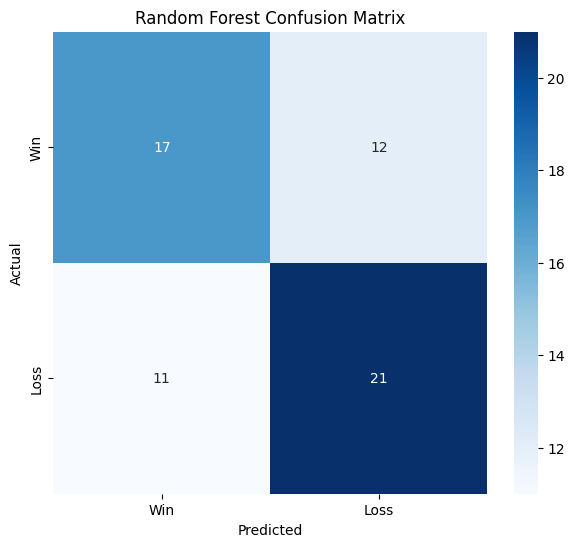

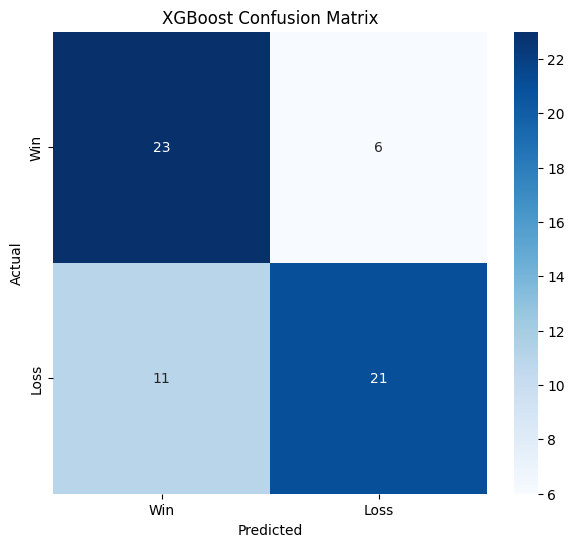

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 随机森林预测结果
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost预测结果
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 计算混淆矩阵
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# 绘制随机森林混淆矩阵热力图
plt.figure(figsize=(7, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Win', 'Loss'], yticklabels=['Win', 'Loss'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 绘制XGBoost混淆矩阵热力图
plt.figure(figsize=(7, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Win', 'Loss'], yticklabels=['Win', 'Loss'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()